In [1]:
import numpy as np
import pandas as pd
import h5py
from scipy.optimize import curve_fit
import datetime as dt
import warnings

from scipy.special import erfc
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt 
plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
import sys
sys.path.insert(0, '../../../purity-monitor/')
sys.path.insert(0, '../../WaveformAnalysis/')
import Dataset as Dataset
import StandMonitor as Monitor
import PlotFunctions as Plt
import importlib
importlib.reload(Dataset)
importlib.reload(Monitor)
importlib.reload(Plt)

<module 'PlotFunctions' from '../../WaveformAnalysis\\PlotFunctions.py'>

In [4]:
# Sensors = []
# Files = ['C:/Data/StandStatus/20211108.h5','C:/Data/StandStatus/20211109.h5']
# for File in Files: 
#     Sensor = Monitor.SensorData(Filepath=File)
#     Sensor.GetData()
#     Sensors.append(Sensor)

# AllSensors = Monitor.SensorData()
# AllSensors.Combine(Sensors)
# XRange = [dt.datetime(2021,11,8,0,0), dt.datetime(2021,11,10,0,0)]
# AllSensors.PlotData(Data=AllSensors.Temp, Selection='Temperature', XTicks=240, YTicks=20, XRange=XRange, YRange=[-120,60])

In [260]:
# Path = 'C:/Data/SiPM/FBK-HD3/'
# Date = '20211108'
# tags = ['24C']
Date = '20211109'
tags = ['GXe_165K_5']
data = {}

for tag in tags:
    file = h5py.File('{}/{}/{}.h5'.format(Path,Date,tag), 'r')
    t_diff_sipm = np.array([float(x) for x in file.keys()])
    data[tag] = {}
    data[tag]['voltage'] = []
    data[tag]['current'] = []
    for ii,group in enumerate(file.keys()):
        # print(ii, group)
        if 'Current' in file[group].keys():
            current = file[group]['Current'][:]
            if len(current)==1:
                continue
            else: 
                data[tag]['voltage'].append(np.array(file[group]['Voltage'][:]))
                data[tag]['current'].append(np.array(file[group]['Current'][:]))
    file.close()
print(len(data[tags[0]]['current']))

61


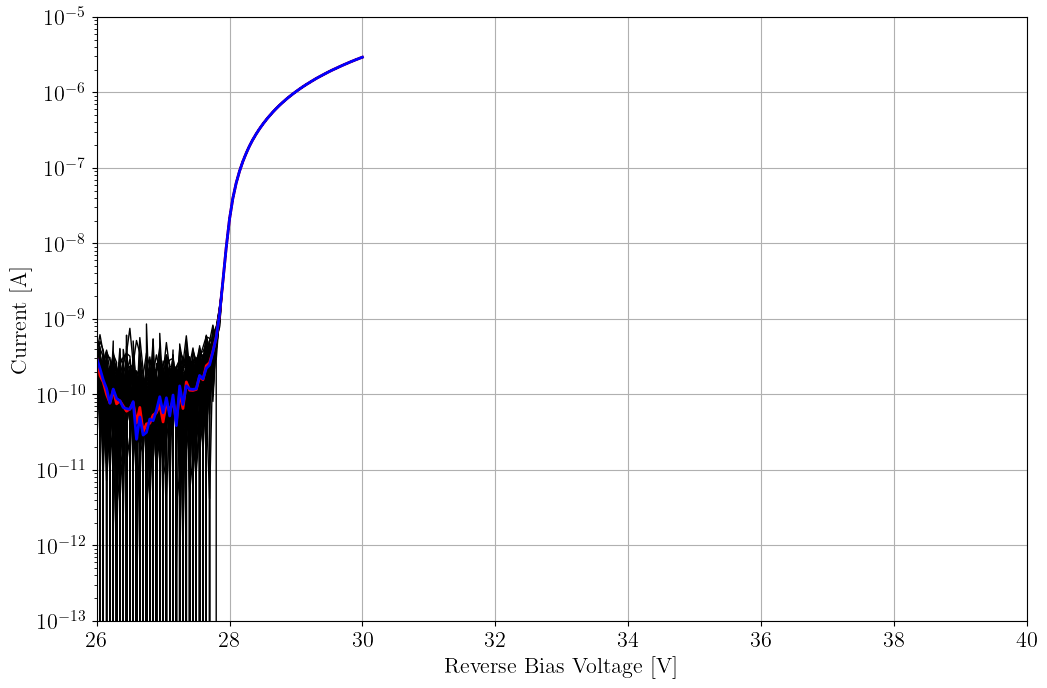

20.2707350034822 [27.9]
20.25216478160474 [27.9]


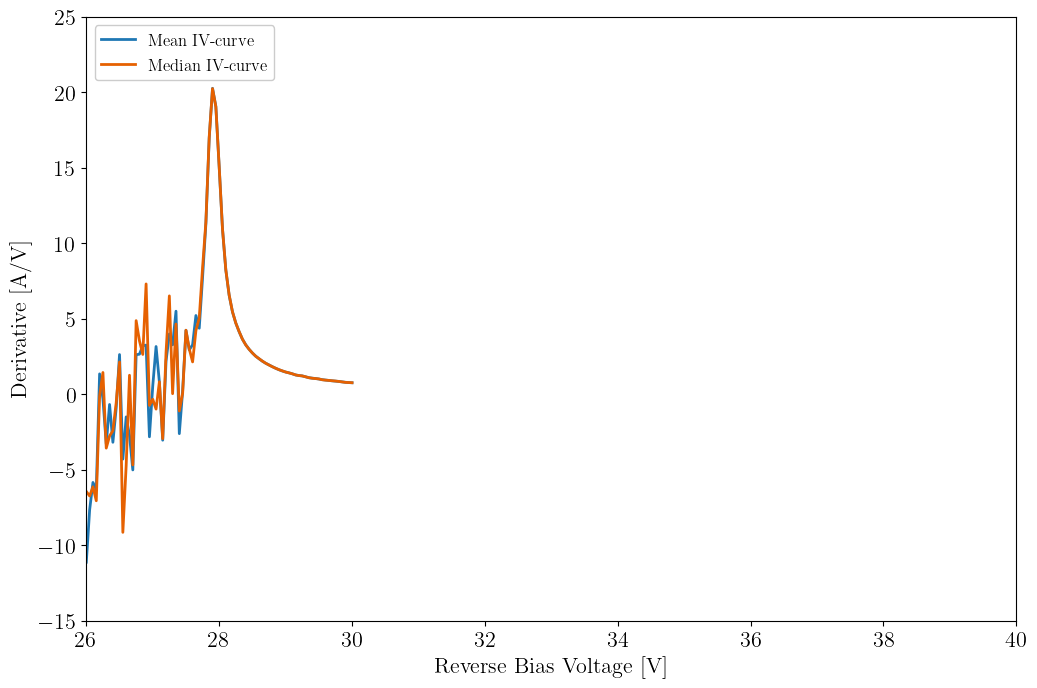

In [261]:
fig = plt.figure(figsize=(12,8))
plt.xlabel('Reverse Bias Voltage [V]')
plt.ylabel('Current [A]')
plt.yscale('log')
plt.grid()
plt.xlim(26,40)

for ii,x in enumerate(data[tags[0]]['current']):
    plt.plot(data[tags[0]]['voltage'][ii], data[tags[0]]['current'][ii], lw=1, color='k')
    # plt.scatter(data[tags[0]]['voltage'][ii], data[tags[0]]['current'][ii], lw=1, color='k')
plt.plot(data[tags[0]]['voltage'][ii], np.mean(data[tags[0]]['current'], axis=0), lw=2, color='r')
plt.plot(data[tags[0]]['voltage'][ii], np.median(data[tags[0]]['current'], axis=0), lw=2, color='b')
plt.show()

mean_curve = np.mean(data[tags[0]]['current'], axis=0)
median_curve = np.median(data[tags[0]]['current'], axis=0)
voltage = data[tags[0]]['voltage'][0]

grad_mean = np.gradient(np.log(mean_curve))/np.gradient(voltage)
grad_median = np.gradient(np.log(median_curve))/np.gradient(voltage)

grad_mean[np.isnan(grad_mean)] = 0
grad_median[np.isnan(grad_median)] = 0

fig = plt.figure(figsize=(12,8))
plt.xlabel('Reverse Bias Voltage [V]')
plt.ylabel('Derivative [A/V]')
# plt.yscale('log')
# plt.grid()
plt.xlim(26,40)

plt.plot(data[tags[0]]['voltage'][ii], grad_mean, lw=2, color=colors[0], label='Mean IV-curve')
plt.plot(data[tags[0]]['voltage'][ii], grad_median, lw=2, color=colors[1], label='Median IV-curve')

plt.legend(loc='upper left')

print(np.max(grad_mean), voltage[np.where(grad_mean == np.max(grad_mean))])
print(np.max(grad_median), voltage[np.where(grad_median == np.max(grad_median))])

plt.show()


In [173]:
# fig = plt.figure(figsize=(12,8))
# plt.xlabel('Reverse Bias Voltage [V]')
# plt.ylabel('Derivative [A/V]')
# plt.grid()
# plt.xlim(25,35)
# plt.ylim(0,10)

# def gauss(x,a,b,c):
#     return a*np.exp(-(x-b)**2/(2*c**2))

# def func(x,V0,sigma,tau,mu):
#         return 0.5*V0 * np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) * erfc(1/np.sqrt(2) * (sigma/tau - (x-mu)/sigma))

# breakdown = []

# for x in range(len(data[tags[0]]['current'])):
#     avg = 10
#     ii = x*avg
#     if ii >= len(data[tags[0]]['current']):
#         break
#     # print(x,ii)
#     voltage = np.mean(data[tags[0]]['voltage'][ii:ii+avg], axis=0)
#     current = np.median(data[tags[0]]['current'][ii:ii+avg], axis=0)

#     grad_v = np.gradient(voltage)
#     grad_i =  np.gradient(np.log(np.abs(current)))
#     grad_i[np.isnan(grad_i)] = 0
    
#     plt.plot(voltage, grad_i/grad_v, color='k', lw=0.5)
#     # plt.scatter(voltage, grad_i/grad_v, color='k', s=5)

#     min_x = 26
#     max_x = 32
#     cut = np.where((voltage<max_x)&(voltage>min_x))[0]

#     v_max = np.max(grad_i/grad_v)
    
#     cut_max = np.where( (grad_i/grad_v)[cut] == np.max((grad_i/grad_v)[cut])  )

#     v_mu = voltage[cut][cut_max][0]
#     v_sig = 0.5
#     # popt,pcov = curve_fit(func, grad_v[cut], grad_i[cut], p0=[v_max,v_mu,v_sig], bounds=([1,28,0.1],[10,32,1]), maxfev=100)
#     popt,pcov = curve_fit(func, grad_v[cut], grad_i[cut], p0=[v_max,0.2,0.5,v_mu-0.1], bounds=([0,0.1,0,25],[100,5,5,32]))
#     # popt,pcov = curve_fit(func, grad_v[cut], grad_i[cut], p0=[*popt], bounds=([0,0.1,0,25],[100,5,5,32]))

#     print(ii,v_max, v_mu, v_sig,popt)
#     xfit = np.linspace(min_x, max_x, 1000)
#     plt.plot(xfit, func(xfit, *popt), color='r', lw=0.4)

#     breakdown.append(popt[3])



# plt.show()
# print(breakdown)


In [9]:
# print(np.mean(breakdown))

In [10]:
# print(t_diff_sipm, breakdown)

In [11]:
# plt.figure()
# plt.scatter(np.array(t_diff_sipm)[::avg], np.array(breakdown))
# plt.show()

In [12]:
# Path = 'C:/Data/SiPM/FBK-HD3/'
# Date = '20211108'
# tags = ['Cooldown']

# t_diff_temp = [(x - dt.datetime(2021, 11, 8, 0, 0, 0)).total_seconds() for x in AllSensors.Time]
# # t_diff_sipm = h5py.File('{}/{}/{}.h5'.format(Path,Date,tag), 'r').keys()

In [13]:
# x = np.linspace(0,100,100)
# plt.figure()
# plt.plot(x, )

In [14]:
# print(len(data[tags[0]]['current']))

In [15]:
# plt.figure()
# for x in range(len(data[tags[0]]['current'])):
#     avg = 10
#     ii = x*avg
#     if ii >= len(data[tags[0]]['current']):
#         break
#     print(x,ii)
#     voltage = np.mean(data[tags[0]]['voltage'][ii:ii+avg], axis=0)
#     current = np.median(data[tags[0]]['current'][ii:ii+avg], axis=0)

#     plt.plot(voltage,current, color='k')

# plt.yscale('log')


In [139]:
# D1 = Dataset.Dataset(Path='C:/Data/20211109/', Selection='SiPM_33V_DCR_SRS_final*.h5')
D1 = Dataset.Dataset(Path='C:/Data/20211109/', Selection='SiPM_33V_LED_SRS_2_*.h5')
# D1 = Dataset.Dataset(Path='C:/Data/20211109/', Selection='SiPM_33V_DCR_SRS_4*.h5')
# D1 = Dataset.Dataset(Path='C:/Data/20211109/', Selection='SiPM_30V_DCR_350Thr*.h5')
# D1 = Dataset.Dataset(Path='C:/Data/20211109/', Selection='SiPM_31V_DCR_350Thr*.h5')
# D1 = Dataset.Dataset(Path='C:/Data/20211109/', Selection='SiPM_33V*.h5')
# D1 = Dataset.Dataset(Path='C:/Data/20211108/', Selection='SiPM_32V_DCR_3_*.h5')
print(len(D1.Files))
D1.Ch[1].Pol = 1
for File in D1.Files:
    D1.ImportDataFromHDF5(File, D1.Ch)

54


In [140]:
Print=True
for ii, ch in enumerate(D1.Ch):
    ch.GetSampling()
    ch.Amp = np.array(ch.Amp)
    ch.TimeStamp = np.array(sorted(ch.TimeStamp))
    ch.Amp = ch.SubtractBaseline(Data=ch.Amp, state=Print)
    ch.GetAllMaxima(Data=ch.Amp, Time=5, state=Print)

 | Subtracting baseline...
 | Getting extrema of individual files...
 | Subtracting baseline...
 | Getting extrema of individual files...


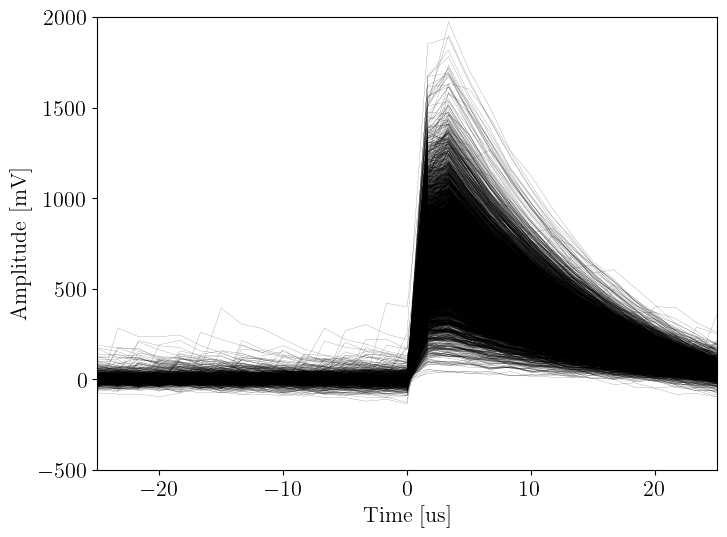

In [141]:
plt.figure()
plt.xlabel('Time [us]')
plt.ylabel('Amplitude [mV]')
plt.xlim(-25,25)
for x in D1.Ch[1].Amp:
    plt.plot(D1.Ch[1].Time, x, color='k', lw=0.1)
plt.show()

5346


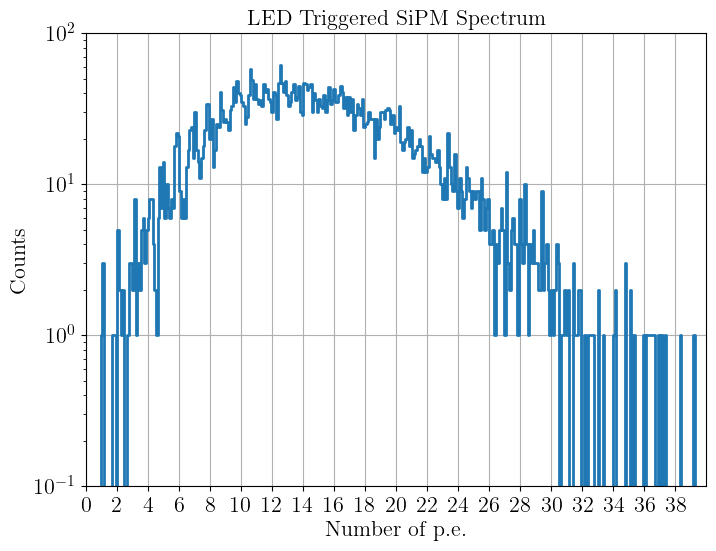

In [150]:
def gauss(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

plt.figure()
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.xlim(0,40)
plt.ylim(0.1,100)
plt.title('LED Triggered SiPM Spectrum')
plt.xticks(np.arange(0,40,2))
plt.grid()

xfit = np.arange(0,3000,10)
h,hx = np.histogram(D1.Ch[1].Max, bins=np.arange(0,2000,5))
plt.step(hx[:-1]/46.3, h, where='mid')
print(np.sum(h))

# gain = []
# noise_cut = np.where(hx>30)[0][:-1]
# gain0 = hx[noise_cut][np.where(h[noise_cut]==np.max(h[noise_cut]))]
# print(gain0)
# for x in [gain0*x for x in range(1,5)]:
#     pe_1 = np.where((hx>x-15) & (hx<x+20))[0]
#     popt1, pcov1 = curve_fit(gauss, hx[pe_1], h[pe_1], 
#                             p0=[np.max(h[pe_1]), hx[pe_1][np.where(h[pe_1]==np.max(h[pe_1]) )[0]][0], 5])
#     plt.plot(hx[pe_1], gauss(hx[pe_1], *popt1), color=colors[1])
#     print(popt1, popt1[2]/popt1[1])

#     gain.append(popt1[1])
plt.savefig('led_spectrum.pdf')
plt.show()

In [ ]:
diff = np.array([gain[0], *np.diff(gain)])
diff_std = np.std(diff)
diff_mean = np.mean(diff)

print(diff)
print(diff_mean)
print(diff_std)

[44.67465417 46.41599863 47.37148319 46.65385961]
46.27899889860023
0.9907993518611015


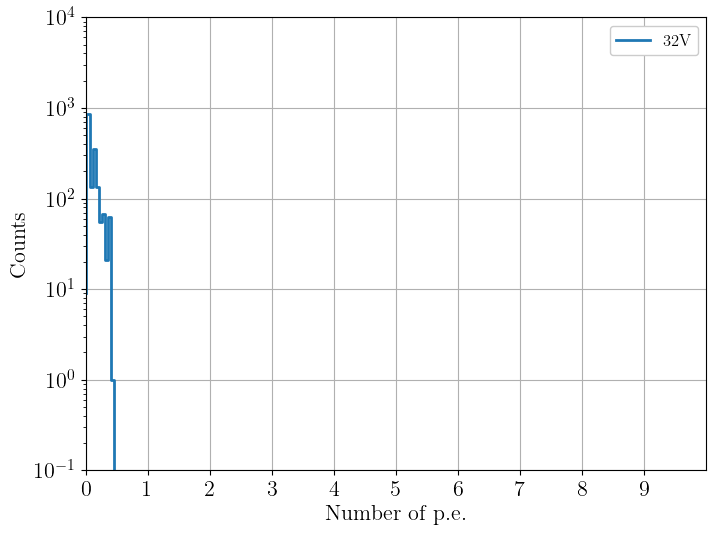

In [ ]:
plt.figure()
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.xlim(0,10)
plt.ylim(0.1,10000)
plt.xticks(np.arange(0,10,1))
plt.grid()

h,hx = np.histogram(D1.Ch[1].Max/diff_mean, bins=np.arange(0,10,0.05))
plt.step(hx[:-1], h, label='32V')
# for x in range(7):
#     plt.vlines(x=x,ymin=0.1,ymax=1e5, ls=':', color='grey')

plt.legend(loc='upper right')
plt.savefig('pulse_height_spectrum.pdf')
plt.show()

[2.49349155 0.07763567]
[137.05000003  27.38197738]
Breakdown voltage is -0.20V


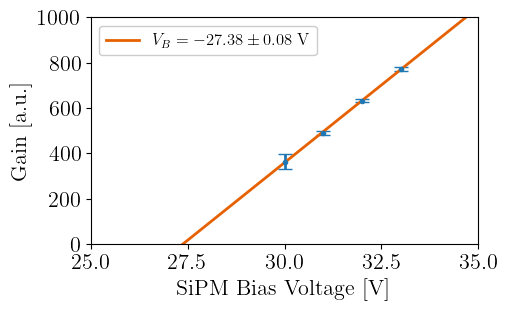

In [217]:
def line_fit(x,a,b):
    return a*(x-b)

bias = [30,31,32,33]
gains = [363,489.5,633,772]
err = [31.9, 9.6,4.9,9.8]

popt, pcov = curve_fit(line_fit, bias, gains)

fit_err = np.sqrt(np.diag(pcov))
print(fit_err)
print(popt)
print('Breakdown voltage is {:.2f}V'.format(-popt[1]/popt[0]))

xfit = np.arange(0,100,1)

plt.figure(figsize=(5,3))
plt.xlim(25,35)
plt.ylim(0,1000)
plt.xlabel('SiPM Bias Voltage [V]')
plt.ylabel('Gain [a.u.]')

plt.errorbar(bias,gains,yerr=err, ls='None', marker='o', ms=3)
plt.plot(xfit, line_fit(xfit, *popt), color=colors[1], label='$V_B={:.2f}\pm{:.2f}\;$V'.format(-popt[1], fit_err[1]))
plt.legend(loc='upper left')
plt.savefig('breakdown_from_gain.pdf')
plt.show()

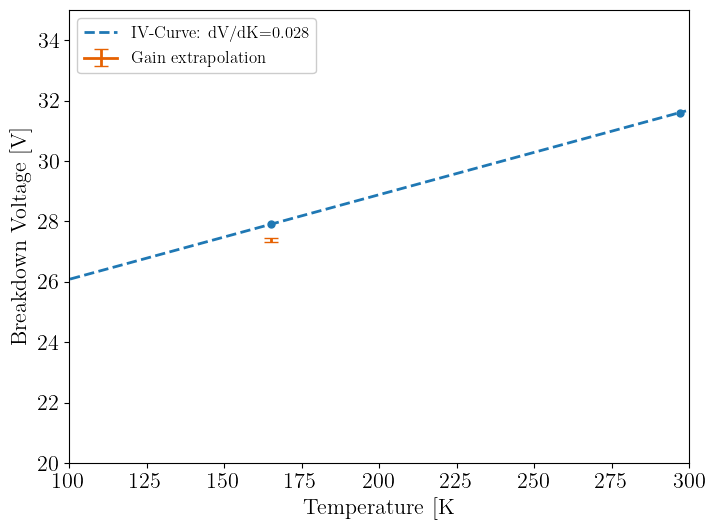

In [259]:

def breakdown(x,a,b):
    return a*(x-b)

def line_fit(x,a,b):
    return a*x+b

temp = [165, 297]
v_bd = [27.9, 31.6]

popt, pcov = curve_fit(line_fit, temp, v_bd)
fit_err = np.sqrt(np.diag(pcov))
xfit = np.arange(0,300,1)

plt.figure()
plt.xlim(100,300)
plt.ylim(20,35)
plt.xlabel('Temperature [K')
plt.ylabel('Breakdown Voltage [V]')

plt.errorbar(temp,v_bd, ls='None', marker='o', ms=5)
plt.errorbar(165, 27.38, yerr=0.08, color=colors[1], ms=10, label='Gain extrapolation')
# plt.plot(xfit, line_fit(xfit, *popt), color=colors[1], label='$V_B={:.2f}\pm{:.2f}\;$V'.format(-popt[1], fit_err[1]))
plt.plot(xfit, line_fit(xfit, *popt), color=colors[0], ls='--', label='IV-Curve: dV/dK={:.3f}'.format(popt[0]))
plt.legend(loc='upper left')
plt.savefig('breakdown_from_gain_and_iv.pdf')
plt.show()